LOAD RAW PATENT DATASET

In [2]:
import pandas as pd
import numpy as np

In [3]:

CSV_PATH = "/Users/jonathan/Desktop/patent_export/ml_patent_base.csv"

CSV_PATH

'/Users/jonathan/Desktop/patent_export/ml_patent_base.csv'

In [5]:
%%time

chunks = []
chunk_size = 200_000

for chunk in pd.read_csv(CSV_PATH, chunksize=chunk_size, low_memory=False):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

df.head()

CPU times: user 19.5 s, sys: 4.18 s, total: 23.7 s
Wall time: 24.3 s


,patent_id,patent_type,patent_date,wipo_kind,num_claims,withdrawn,filename,patent_year,patent_month,patent_day,...,title_length,filename_length,wipo_kind_numeric,time_to_issue_days,cpc_section_breadth,early_cpc_flag,assignee_is_company,assignee_is_individual,influence_score,is_summer_grant
0,8769860,utility,2014-07-08,B2,24,f,ipg140708.xml,2014,7,8,...,13,13,2.0,1056.0,NaN,1,NaN,NaN,-6,1
1,D989886,design,2023-06-20,S1,1,f,ipg230620.xml,2023,6,20,...,13,13,1.0,646.0,NaN,0,NaN,NaN,-12,1
2,D962054,design,2022-08-30,S1,1,f,ipg220830.xml,2022,8,30,...,13,13,1.0,454.0,NaN,0,NaN,NaN,-18,1
3,D998476,design,2023-09-12,S1,1,f,ipg230912.xml,2023,9,12,...,13,13,1.0,685.0,NaN,0,NaN,NaN,-5,0
4,D998840,design,2023-09-12,S1,1,f,ipg230912.xml,2023,9,12,...,13,13,1.0,112.0,NaN,0,NaN,NaN,-5,0


BASIC DATA INSPECTION

In [6]:
df.info()
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9256345 entries, 0 to 9256344
Data columns (total 34 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   patent_id               object 
 1   patent_type             object 
 2   patent_date             object 
 3   wipo_kind               object 
 4   num_claims              int64  
 5   withdrawn               object 
 6   filename                object 
 7   patent_year             int64  
 8   patent_month            int64  
 9   patent_day              int64  
 10  filing_date_parsed      object 
 11  filing_year             float64
 12  filing_month            float64
 13  filing_day              float64
 14  inventor_count          int64  
 15  assignee_count          int64  
 16  citations_made          int64  
 17  citations_received      int64  
 18  cpc_count               int64  
 19  uspc_count              int64  
 20  has_assignee            int64  
 21  multiple_inventors      int64  

primary_cpc_section       5742821
cpc_section_breadth       5742639
wipo_kind_numeric         2619917
assignee_is_individual    1003752
assignee_is_company       1003752
time_to_issue_days           2259
filing_date_parsed           2259
filing_year                  2259
filing_month                 2259
filing_day                   2259
patent_id                       0
title_length                    0
multiple_inventors              0
withdrawn_flag                  0
filename_length                 0
uspc_count                      0
early_cpc_flag                  0
influence_score                 0
has_assignee                    0
citations_received              0
cpc_count                       0
patent_type                     0
citations_made                  0
assignee_count                  0
inventor_count                  0
patent_day                      0
patent_month                    0
patent_year                     0
filename                        0
withdrawn     

DATA CLEANING AND PREPROCESSING

In [ ]:
import pandas as pd
import numpy as np

df_clean = df.copy()

df_clean["patent_date"] = pd.to_datetime(df_clean["patent_date"], errors="coerce")
df_clean["filing_date_parsed"] = pd.to_datetime(df_clean["filing_date_parsed"], errors="coerce")
df_clean = df_clean[df_clean["patent_date"].notna()]

df_clean["assignee_is_company"] = df_clean["assignee_is_company"].fillna(0).astype(int)
df_clean["assignee_is_individual"] = df_clean["assignee_is_individual"].fillna(0).astype(int)
df_clean["withdrawn_flag"] = df_clean["withdrawn_flag"].fillna(0).astype(int)

df_clean["primary_cpc_section"] = df_clean["primary_cpc_section"].fillna("None")

df_clean["time_to_issue_days"] = df_clean["time_to_issue_days"].fillna(-1)
df_clean = df_clean[
    (df_clean["time_to_issue_days"] > 0) &
    (df_clean["time_to_issue_days"] < 4000)
]

numeric_cols = [
    "num_claims", "inventor_count", "assignee_count",
    "citations_received", "citations_made",
    "cpc_count", "uspc_count"
]

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(0)
    df_clean = df_clean[df_clean[col] >= 0]

df_clean["is_post_aia"] = (df_clean["filing_year"] >= 2013).astype(int)

cols_to_drop = [
    "filename",
    "withdrawn",
    "filename_length",
    "wipo_kind_numeric",
    "cpc_section_breadth"
]

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")

print("Final cleaned df_clean shape:", df_clean.shape)

Final cleaned df_clean shape: (9241283, 30)


TIME-TO-ISSUE LABEL

In [ ]:
df_tti = df_clean.copy()

df_tti = df_tti[df_tti["filing_date_parsed"].notna()]

df_tti = df_tti[(df_tti["filing_year"] >= 2010) & (df_tti["filing_year"] <= 2020)]
df_tti = df_tti[df_tti["patent_date"] >= df_tti["filing_date_parsed"]]

df_tti["time_to_issue_days_clean"] = (
    df_tti["patent_date"] - df_tti["filing_date_parsed"]
).dt.days

df_tti = df_tti[
    (df_tti["time_to_issue_days_clean"] > 0) &
    (df_tti["time_to_issue_days_clean"] < 4000)
]

print("TTI rows:", df_tti.shape)
print("Mean TTI:", df_tti["time_to_issue_days_clean"].mean())

TTI rows: (3597867, 31)
Mean TTI: 986.1790911114836


TIME-TO-ISSUE REGRESSION MODEL (CATBOOST)

In [ ]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Full TTI dataset:", df_tti.shape)

df = df_tti.sample(n=200000, random_state=42).copy()
print("Sample size:", df.shape)

y = df["time_to_issue_days_clean"]

numeric_features = [
    "filing_year", "filing_month", "filing_day",
    "num_claims", "inventor_count", "assignee_count",
    "cpc_count", "citations_made", "citations_received",
    "early_cpc_flag", "has_assignee", "multiple_inventors",
    "is_post_aia"
]

categorical_features = [
    "patent_type",
    "wipo_kind",
    "primary_cpc_section"
]

X = df[numeric_features + categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool  = Pool(X_test,  y_test,  cat_features=categorical_features)

model = CatBoostRegressor(
    iterations=600,
    depth=8,
    learning_rate=0.06,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("\nCATBOOST TTI RESULTS BELOW")
print(f"MAE : {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R²  : {r2:.3f}")

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 15 TTI Features:")
print(fi.head(15).to_string(index=False))


Full TTI dataset: (3597867, 31)
Sample size: (200000, 31)
0:	learn: 492.3140948	test: 490.8367412	best: 490.8367412 (0)	total: 106ms	remaining: 1m 3s
100:	learn: 409.7313203	test: 407.5416656	best: 407.5416656 (100)	total: 5.47s	remaining: 27s
200:	learn: 406.7501191	test: 405.9959179	best: 405.9959179 (200)	total: 10.3s	remaining: 20.5s
300:	learn: 404.5406808	test: 405.4355990	best: 405.4355990 (300)	total: 15.5s	remaining: 15.4s
400:	learn: 402.9120439	test: 405.3012881	best: 405.2955438 (385)	total: 20.7s	remaining: 10.3s
500:	learn: 401.5107354	test: 405.2221319	best: 405.2171705 (499)	total: 26s	remaining: 5.13s
599:	learn: 400.2259455	test: 405.1655518	best: 405.1534318 (555)	total: 31.3s	remaining: 0us

bestTest = 405.1534318
bestIteration = 555

Shrink model to first 556 iterations.

===== CATBOOST TTI RESULTS =====
MAE : 313.19 days
RMSE: 405.15 days
R²  : 0.340

Top 15 TTI Features:
            feature  importance
          cpc_count   28.570151
        filing_year   20.1936

PREDICTED VS. ACTUAL SCATTER

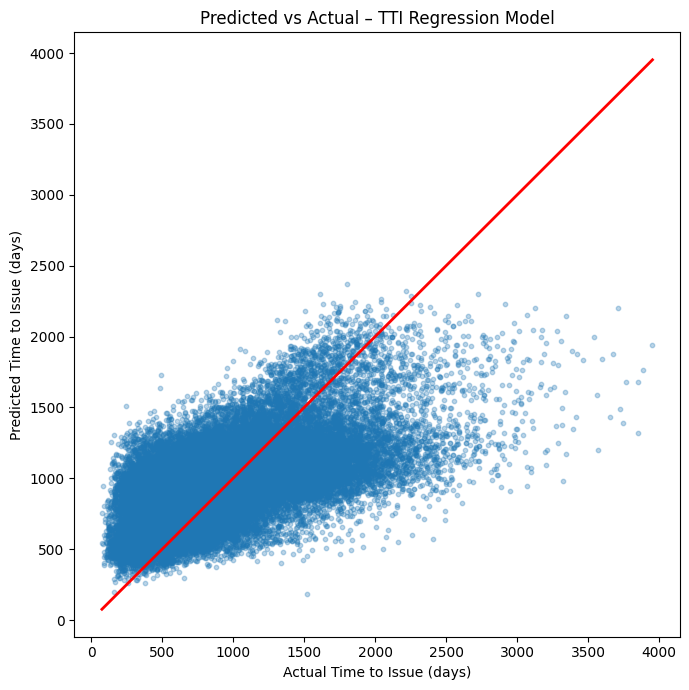

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2)

plt.title("Predicted vs Actual – TTI Regression Model")
plt.xlabel("Actual Time to Issue (days)")
plt.ylabel("Predicted Time to Issue (days)")
plt.tight_layout()
plt.show()

RESIDUALS VS. PREDICTED PLOT

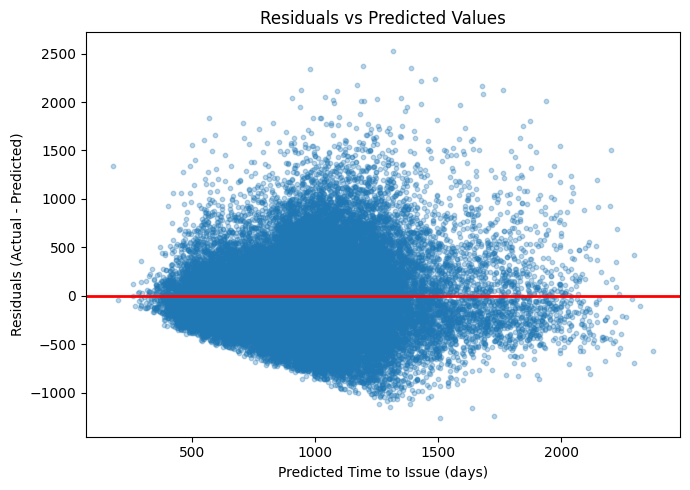

In [11]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.3, s=10)
plt.axhline(0, color='red', linewidth=2)

plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Time to Issue (days)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE BAR PLOT

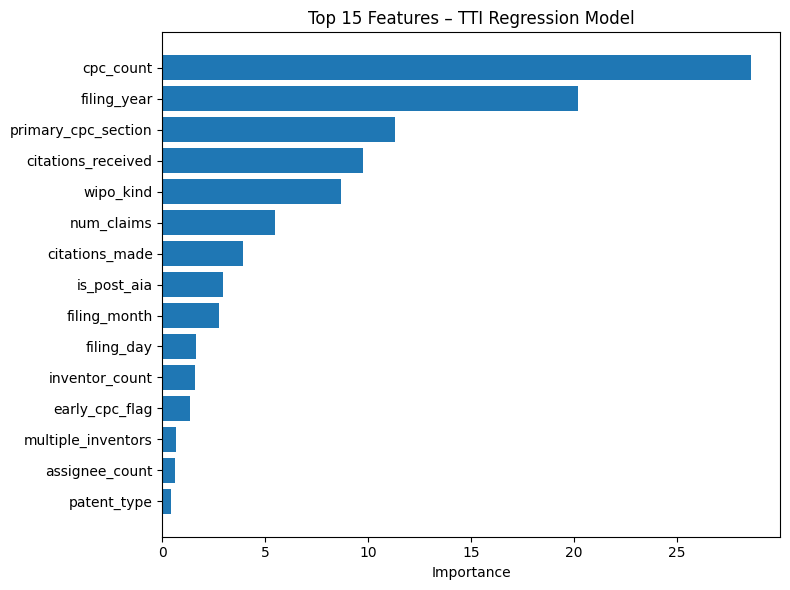

In [12]:
top_fi = fi.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_fi["feature"], top_fi["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 15 Features – TTI Regression Model")
plt.tight_layout()
plt.show()

TTI CLASSIFICATION (4 BUCKETS)

In [9]:
def categorize_tti(days):
    if days < 18 * 30:
        return 0
    elif days < 36 * 30:
        return 1
    elif days < 60 * 30:
        return 2
    else:
        return 3

df_tti["tti_bucket"] = df_tti["time_to_issue_days_clean"].apply(categorize_tti)

df_tti["tti_bucket"].value_counts(normalize=True)

tti_bucket
1    0.441005
2    0.299886
0    0.190557
3    0.068553
Name: proportion, dtype: float64

SUMMARY OF RESULTS

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = df_tti.sample(n=200000, random_state=42).copy()

y = df["tti_bucket"]

numeric_features = [
    "filing_year", "filing_month", "filing_day",
    "num_claims", "inventor_count", "assignee_count",
    "cpc_count", "citations_made", "citations_received",
    "early_cpc_flag", "has_assignee", "multiple_inventors",
    "is_post_aia"
]

categorical_features = [
    "patent_type",
    "wipo_kind",
    "primary_cpc_section"
]

X = df[numeric_features + categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool  = Pool(X_test, y_test, cat_features=categorical_features)

model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.07,
    loss_function="MultiClass",
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nTTI BUCKET CLASSIFICATION RESULTS BELOW")
print(f"Accuracy: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop Features:")
print(fi.head(15).to_string(index=False))

0:	learn: 1.3484181	test: 1.3481396	best: 1.3481396 (0)	total: 485ms	remaining: 4m 2s
100:	learn: 1.0160730	test: 1.0211236	best: 1.0211236 (100)	total: 38.3s	remaining: 2m 31s
200:	learn: 1.0014158	test: 1.0138153	best: 1.0138153 (200)	total: 1m 17s	remaining: 1m 55s
300:	learn: 0.9886791	test: 1.0108454	best: 1.0108454 (300)	total: 1m 54s	remaining: 1m 15s
400:	learn: 0.9780115	test: 1.0097514	best: 1.0097393 (393)	total: 2m 28s	remaining: 36.7s
499:	learn: 0.9687509	test: 1.0094867	best: 1.0094012 (494)	total: 3m 2s	remaining: 0us

bestTest = 1.00940116
bestIteration = 494

Shrink model to first 495 iterations.

===== TTI BUCKET CLASSIFICATION RESULTS =====
Accuracy: 0.528

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.32      0.42      7686
           1       0.52      0.77      0.62     17637
           2       0.50      0.41      0.45     11983
           3       0.61      0.08      0.14      2694

    accuracy       

4-BUCKET FEATURE IMPORTANCE

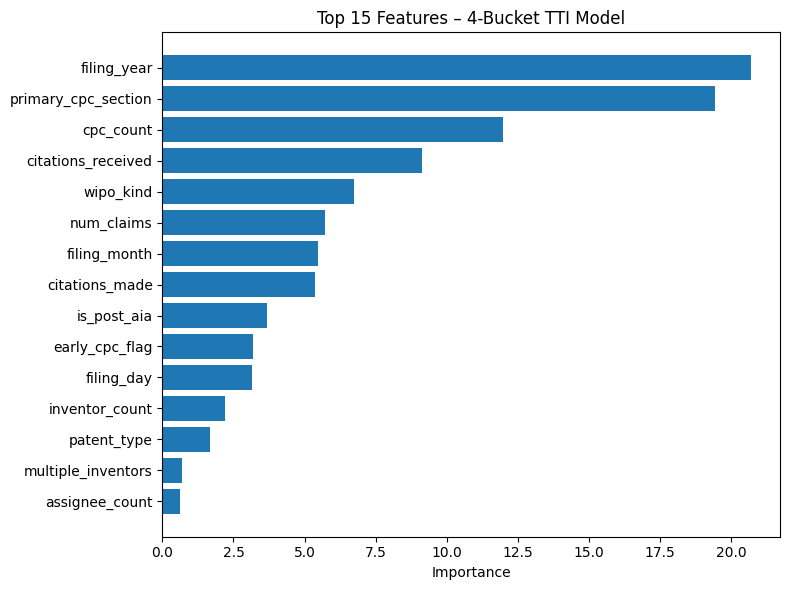

In [19]:
import matplotlib.pyplot as plt

fi_4 = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(fi_4["feature"].head(15), fi_4["importance"].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Features – 4-Bucket TTI Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

4-BUCKET CONFUSION MATRIX

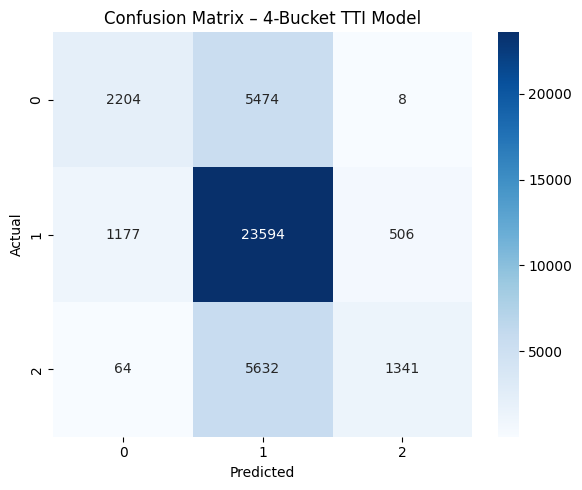

In [21]:
import seaborn as sns

cm_4 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_4, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – 4-Bucket TTI Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

4-BUCKET NORMALIZED CONFUSION MATRIX

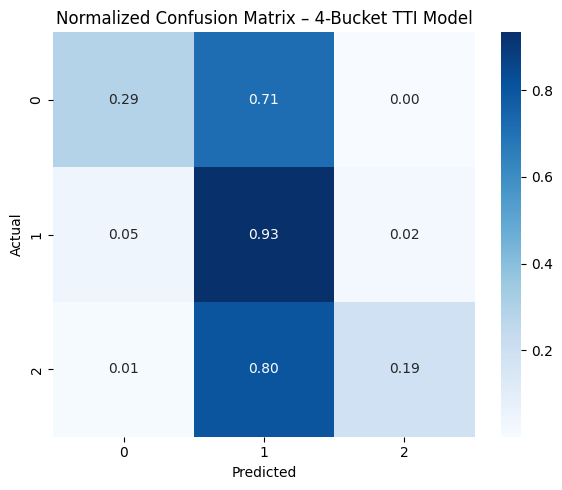

In [22]:
cm_norm_4 = cm_4 / cm_4.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm_4, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix – 4-Bucket TTI Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

TTI CLASSIFICATION (3 BUCKETS)

In [13]:
def categorize_tti_3(days):
    if days < 18 * 30:
        return 0         
    elif days < 48 * 30:
        return 1          
    else:
        return 2          

df_tti["tti_bucket_3"] = df_tti["time_to_issue_days_clean"].apply(categorize_tti_3)

df_tti["tti_bucket_3"].value_counts(normalize=True)

tti_bucket_3
1    0.632370
0    0.190557
2    0.177074
Name: proportion, dtype: float64

SUMMARY OF RESULTS

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = df_tti.sample(n=200000, random_state=42).copy()

y = df["tti_bucket_3"]

numeric_features = [
    "filing_year", "filing_month", "filing_day",
    "num_claims", "inventor_count", "assignee_count",
    "cpc_count", "citations_made", "citations_received",
    "early_cpc_flag", "has_assignee", "multiple_inventors",
    "is_post_aia"
]

categorical_features = [
    "patent_type",
    "wipo_kind",
    "primary_cpc_section"
]

X = df[numeric_features + categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool  = Pool(X_test,  y_test,  cat_features=categorical_features)

model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.07,
    loss_function="MultiClass",
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nTTI 3-BUCKET CLASSIFICATION RESULTS BELOW")
print(f"Accuracy: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

fi = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop Features:")
print(fi.head(15).to_string(index=False))

0:	learn: 1.0583299	test: 1.0582903	best: 1.0582903 (0)	total: 178ms	remaining: 1m 28s
100:	learn: 0.7400448	test: 0.7460261	best: 0.7460261 (100)	total: 21.3s	remaining: 1m 24s
200:	learn: 0.7283225	test: 0.7398717	best: 0.7398717 (200)	total: 42.6s	remaining: 1m 3s
300:	learn: 0.7198849	test: 0.7382740	best: 0.7382740 (300)	total: 1m 3s	remaining: 42.2s
400:	learn: 0.7126653	test: 0.7375901	best: 0.7375901 (400)	total: 1m 25s	remaining: 21.2s
499:	learn: 0.7060647	test: 0.7373361	best: 0.7372892 (474)	total: 1m 47s	remaining: 0us

bestTest = 0.7372891658
bestIteration = 474

Shrink model to first 475 iterations.

===== TTI 3-BUCKET CLASSIFICATION RESULTS =====
Accuracy: 0.678

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.29      0.40      7686
           1       0.68      0.93      0.79     25277
           2       0.72      0.19      0.30      7037

    accuracy                           0.68     40000
   macro avg     

3-BUCKET FEATURE IMPORTANCE

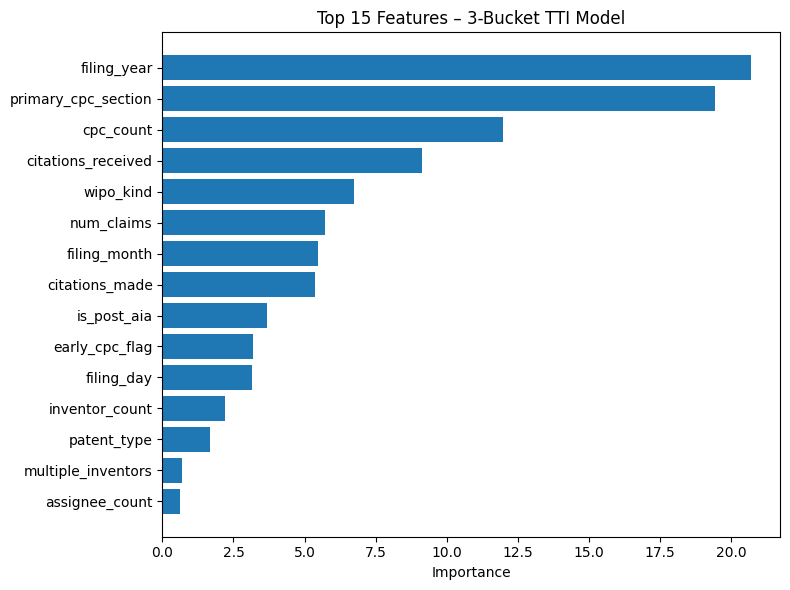

In [ ]:
import matplotlib.pyplot as plt

fi_3 = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(fi_3["feature"].head(15), fi_3["importance"].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Features – 3-Bucket TTI Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

3-BUCKET CONFUSION MATRIX

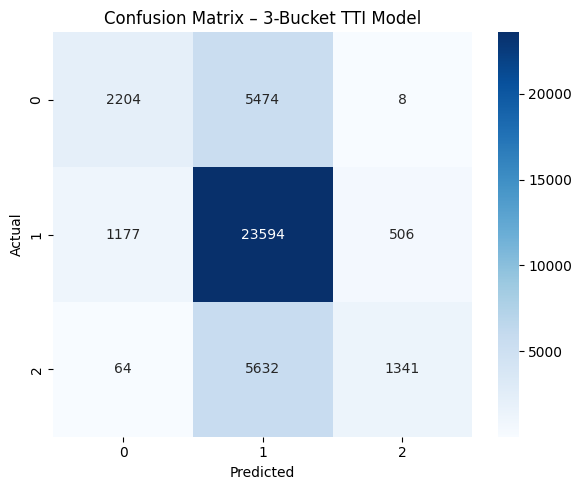

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – 3-Bucket TTI Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

3-BUCKET NORMALIZED CONFUSION MATRIX

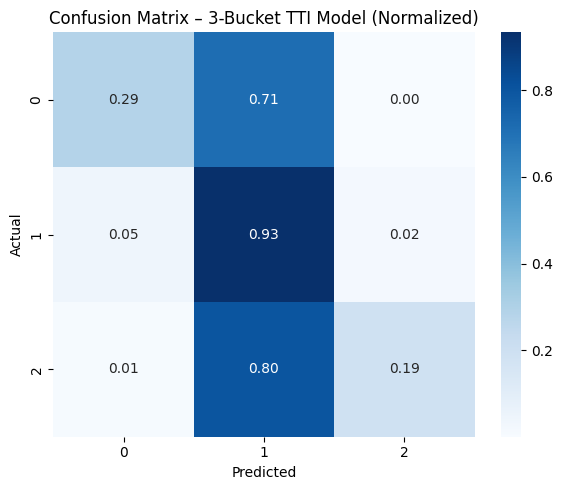

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix – 3-Bucket TTI Model (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()